* Indexing method for making dictionary keys - DONE
* each position is an object with index but also list showing cRDS - DONE
* CAN PASS CARDS TO MC SO NO NEED TO BACK CONVERT. JUST USED AS A KEY. LIST IS USED FOR SCORING AND MC - DONE
* Create full list of positions - DONE
* Function to convert index keys to simulation inputs - DONE
* MC simulation - DONE
* Exact analytical solution - DONE
* Algo for using simulation to solve for strategy
* Compare analytical and numerical solution - DONE
* Compare analytical and numerical strategy

In [23]:
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
#Example index: 17000000001001
#Example_hand: [7,0,0,0,0,0,0,0,0,10,1]
#11000000000002 is dealer with a 10

To do:
* Reorder function to a more logical ordering
* Check winner function that takes two scores as input and outputs 1,2,3
* Move analyitcal solution to class method
* Any function that relies on a class should be a method. No such thing as lalal(position)

rules for index
dealer 0 is a 10

In [24]:
def cardsToIndex(player_hand, dealer_card, draw = None):
    #1 is a 10
    #0 is a ace
    index_scaling = [10**11, 10**10, 10**9, 10**8, 10**7, 10**6, 10**5, 10**4, 10**2, 10**0]
    index = 10000000000000 + dealer_card*10**12
    if draw != None:
        player_hand[10 - draw] += 1
    for card in range(10):
        index += index_scaling[card] * player_hand[card]
    return index

In [25]:
def indexToCards(index):#TODO
    index = list(str(index)[1:])
    dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    dealer_hand[9 - int(index[0])] += 1
    index = index[1:]
    return [int(x) for x in index[0:-4] + [index[-4] + index[-3]] + [index[-2] + index[-1]]], dealer_hand

In [26]:
def score(player_cards):
    score = player_cards[-1] * 11
    high_aces = player_cards[-1]
    for cardIndex in range(9):
        score += (10 - cardIndex) * player_cards[cardIndex]
    #Determine whether to use aces as 1 or 11
    while score > 21 and high_aces > 0:
        if high_aces > 0:
            score -= 10
            high_aces -= 1
    return score 

In [27]:
def simulateGames(position, number_games = 1000):#TODO
    player_wins, dealer_wins, ties = 0, 0, 0
    dealer_card = position.dealer_face
    player_score = position.score
    draw_weights = np.array([x - y for x, y in zip([card*position.decks for card in [16, 4, 4, 4, 4, 4, 4, 4, 4, 4]], position.cards_in_play)])
    base_weights = []
    for i in range(10):
        base_weights += [10 - i]*draw_weights[i]

    base_dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    base_dealer_hand[10 - dealer_card] += 1

    while number_games > 0:
        temp_weights = base_weights.copy()
        dealer_hand = base_dealer_hand.copy()
        dealer_score = 0
        while dealer_score < 17:
            card = temp_weights.pop(rn.randint(0, len(temp_weights) - 1))
            dealer_hand[10 - card] += 1
            dealer_score = score(dealer_hand)
        if player_score < 22:
            if player_score > dealer_score:
                player_wins += 1
            if player_score < dealer_score and dealer_score < 22:
                dealer_wins +=1
            if dealer_score > 21:
                player_wins +=1
            if player_score == dealer_score:
                ties += 1
        if player_score > 21:
            dealer_wins += 1

        number_games -= 1 
    return (player_wins - dealer_wins)/(player_wins + dealer_wins + ties)

In [28]:
def deckContents(position):
    return np.array([x - y for x, y in zip([card*position.decks for card in [16, 4, 4, 4, 4, 4, 4, 4, 4, 4]], position.cards_in_play)])

In [29]:
class Position:
    def __init__(self, index = None, cards = None, dealer_card = None, draw = None, decks = 1):
        #10 card is a 1 in dealer cardsTo, ace is a 0
        self.dealer_face = dict(zip(range(0,10), [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]))[dealer_card]
        if index != None:
            self.index = index
            self.player_hand, self.dealer_hand = indexToCards(self.index)
        if index == None:
            self.player_hand = cards
            self.dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            self.dealer_hand[10 - self.dealer_face] += 1
            self.index = cardsToIndex(self.player_hand, dealer_card, draw)
        self.hand_size = len(self.player_hand)
        self.score = score(self.player_hand)
        self.bust = True if self.score > 21 else False
        self.decks = decks

        self.cards_in_play = [x + y for x, y in zip(self.player_hand, self.dealer_hand)]

        self.valid = True if all(x < 4*self.decks + 1  for x in self.cards_in_play[1:]) and self.cards_in_play[0] < 16*self.decks + 1 else False

    def get_stick_probability(self, simulations):
        self.stick_probability = simulateGames(self, number_games = simulations)

In [30]:
def getPositions(decks = 1):
    Next = {10000000000000 : Position(index = 10000000000000, dealer_card = 1)}
    Master = {}
    runs = 0
    while len(Next) != 0:
        Current = Next
        Next = {}
        for position in Current.values():
            for drawn in range(1, 11):
                gate = True
                for dealer_card in range(0, 10):#This causes cards to index problems. Maybe best ro do range(10)
                    temp = position.player_hand.copy()
                    current_position = Position(cards = temp, draw = drawn, dealer_card = dealer_card, decks = decks)
                    if not current_position.bust and current_position.valid:
                        if gate:
                            Next[current_position.index] = current_position
                            gate = False
                        if runs > 0:
                            Master[current_position.index] = current_position
        runs += 1
    return Master

In [31]:
class Strategy:
    def __init__(self, decks = 1):
        self.positions = getPositions(decks = decks)
    
    def get_stick_probability(self, simulations):
        for position in self.positions.values():
            position.get_stick_probability(simulations)

In [32]:
def analyticalSolution(position):
    deck_contents = deckContents(position)
    total_cards_in_deck = sum(deck_contents)
    Master = {}
    Next = {"".join(map(str, position.dealer_hand)): [position.dealer_hand, 1]}
    Depth = 0
    while len(Next) != 0:
        Current = Next.copy()
        Next = {}
        for hand_index in Current.keys():
            for drawn_card in range(1,11):
                hand = Current[hand_index][0].copy()
                comparison = hand.copy()#Improve this and next two lines :/
                comparison[10 - position.dealer_face] -= 1
                if comparison[10 - drawn_card] < deck_contents[10 - drawn_card]:
                    next_index_cards = hand.copy()
                    next_index_cards[10 - drawn_card] += 1
                    next_index = "".join(map(str, next_index_cards))
                    next_score = score(next_index_cards)
                    hand[10 - position.dealer_face] -= 1
                    if next_score < 17:
                        if next_index not in Next.keys():
                            Next[next_index] = [next_index_cards, 0]
                        Next[next_index][1] += Current[hand_index][1] * (deck_contents[10 - drawn_card] - hand[10 - drawn_card])/(total_cards_in_deck - Depth)
                    else:
                        if next_index not in Master.keys():
                            Master[next_index] = [0, next_score]
                        Master[next_index][0] += Current[hand_index][1] * (deck_contents[10 - drawn_card] - hand[10 - drawn_card])/(total_cards_in_deck - Depth)
        Depth += 1

    count = [0,0,0]
    score_outcomes = {}
    player_score = position.score
    for possible_dealer_score in range(17, 27):
        if (position.score < 22):
            if (position.score > possible_dealer_score):
                score_outcomes[possible_dealer_score] = 0
            if position.score < possible_dealer_score and possible_dealer_score < 22:
                score_outcomes[possible_dealer_score] =  1
            if (possible_dealer_score > 21):
                score_outcomes[possible_dealer_score] = 0
            if (position.score == possible_dealer_score):
                score_outcomes[possible_dealer_score] = 2
        else:
            score_outcomes[possible_dealer_score] = 1

    for check in Master.keys():
        count[score_outcomes[Master[check][1]]] += Master[check][0]

    return (count[0] - count[1])/sum(count)

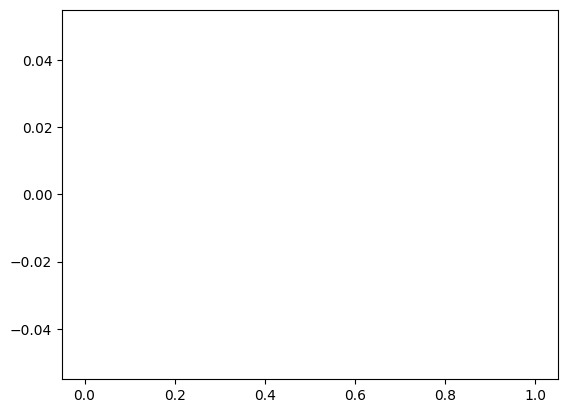

In [33]:
strategy = Strategy()
strategy.get_stick_probability(1000)
errors = []
plt.hist(errors, bins = 100)
plt.show()
for i in strategy.positions.values():
    errors.append(analyticalSolution(i) - i.stick_probability)

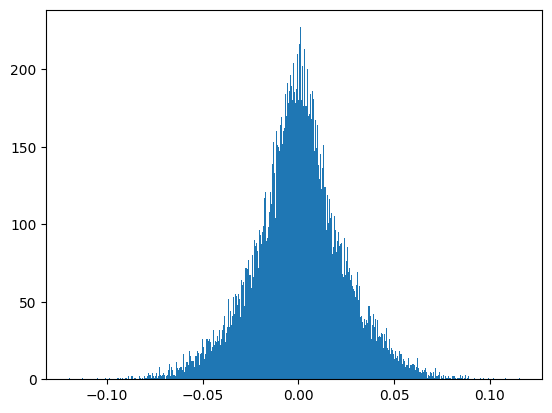

In [37]:
plt.hist(errors, bins = 500)
plt.show()

In [35]:
np.mean(errors)

2.8492036676751044e-05